8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

=== Tổng hợp kết quả các mô hình ===
                       MAE      RMSE       ACC        F1
Naive             0.650913  0.891932  1.000000  1.000000
LinearRegression  0.696702  0.938550       NaN       NaN
RandomForest      1.013418  1.344277       NaN       NaN
GradientBoosting  1.005550  1.422549       NaN       NaN
DNN_Regressor     0.765315  1.017871       NaN       NaN
DNN_Classifier         NaN       NaN  0.761905  0.719626

✅ Mô hình tốt nhất (RMSE thấp nhất): Naive


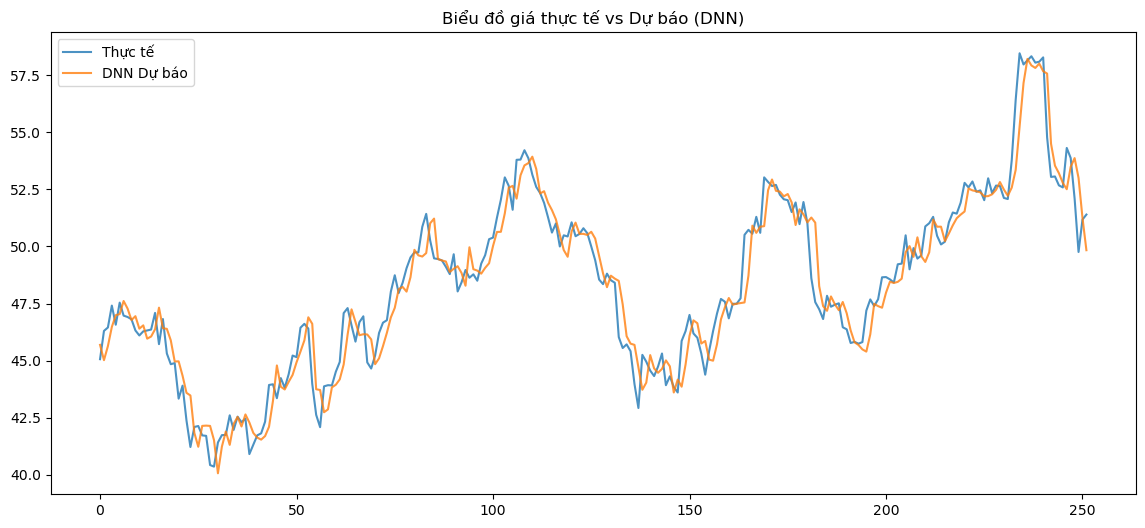

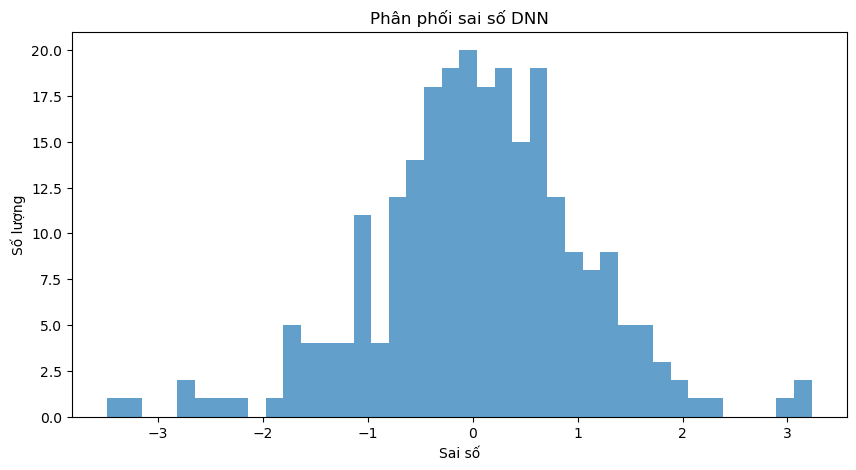

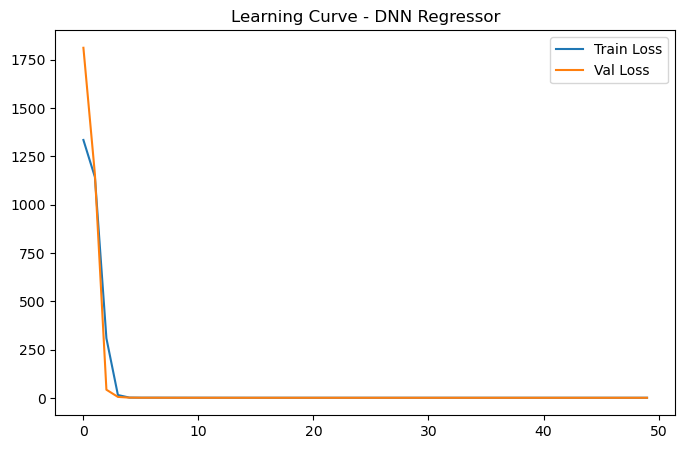

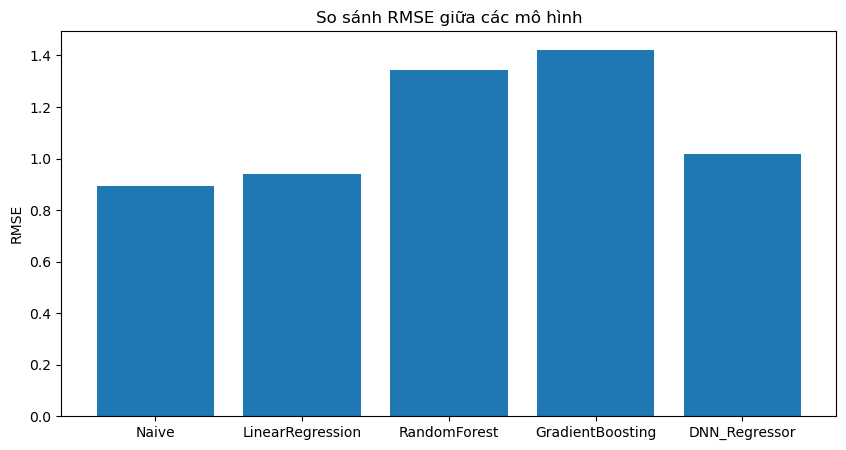

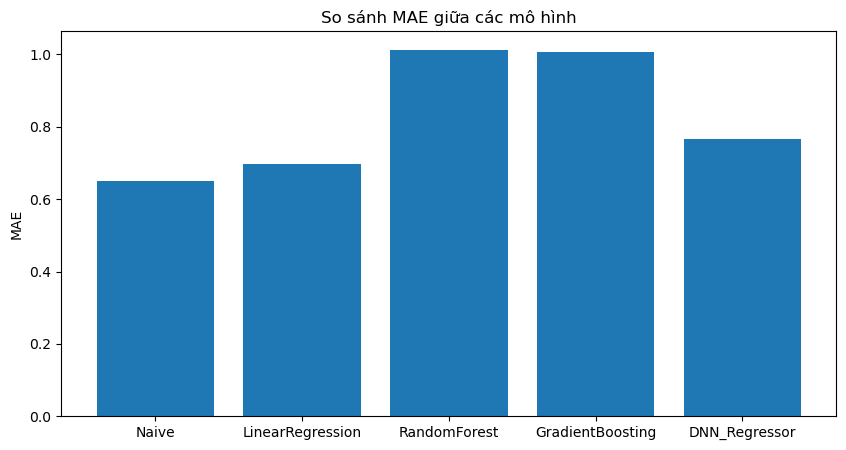


Hoàn tất ✅. Các biểu đồ và kết quả đã được hiển thị.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score
import tensorflow as tf

# ===============================
# 1. Đọc và chuẩn hóa dữ liệu
# ===============================
df = pd.read_csv("all_stocks_5yr.csv")
df = df[df['Name'] == 'AAL']  # ví dụ dự báo cho mã AAL
df = df.dropna()

# Thêm cột tỷ suất lợi nhuận và hướng tăng/giảm
df['return'] = df['close'].pct_change()
df['direction'] = (df['return'] > 0).astype(int)
df = df.dropna()

# ===============================
# 2. Tạo đặc trưng
# ===============================
feature_cols = ['open', 'high', 'low', 'volume']
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Shift giá đóng cửa hôm sau làm nhãn
df['target_close'] = df['close'].shift(-1)
df = df.dropna()

# Tập huấn luyện và kiểm thử
split_idx = int(len(df) * 0.8)
X = df[feature_cols]
y_reg = df['target_close']
y_clf = df['direction']

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
yreg_train, yreg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
yclf_train, yclf_test = y_clf.iloc[:split_idx], y_clf.iloc[split_idx:]

# ===============================
# 3. Baseline Models
# ===============================
results = {}

# --- (1) Naive baseline ---
y_pred_naive = df['close'].iloc[split_idx:].values  # dự báo = giá hôm nay
mae_naive = mean_absolute_error(yreg_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(yreg_test, y_pred_naive))
pred_dir_naive = (df['return'].iloc[split_idx:] > 0).astype(int)
acc_naive = accuracy_score(yclf_test, pred_dir_naive)
f1_naive = f1_score(yclf_test, pred_dir_naive)
results['Naive'] = {'MAE': mae_naive, 'RMSE': rmse_naive, 'ACC': acc_naive, 'F1': f1_naive}

# --- (2) Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, yreg_train)
y_lr = lr.predict(X_test)
results['LinearRegression'] = {
    'MAE': mean_absolute_error(yreg_test, y_lr),
    'RMSE': np.sqrt(mean_squared_error(yreg_test, y_lr))
}

# --- (3) Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, yreg_train)
y_rf = rf.predict(X_test)
results['RandomForest'] = {
    'MAE': mean_absolute_error(yreg_test, y_rf),
    'RMSE': np.sqrt(mean_squared_error(yreg_test, y_rf))
}

# --- (4) Gradient Boosting ---
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, yreg_train)
y_gb = gb.predict(X_test)
results['GradientBoosting'] = {
    'MAE': mean_absolute_error(yreg_test, y_gb),
    'RMSE': np.sqrt(mean_squared_error(yreg_test, y_gb))
}

# ===============================
# 4. DNN ≥ 5 layers
# ===============================
tf.keras.utils.set_random_seed(42)

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)  # output: giá close
])

dnn_model.compile(optimizer='adam', loss='mse')
history = dnn_model.fit(X_train, yreg_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
y_dnn_reg = dnn_model.predict(X_test).flatten()
results['DNN_Regressor'] = {
    'MAE': mean_absolute_error(yreg_test, y_dnn_reg),
    'RMSE': np.sqrt(mean_squared_error(yreg_test, y_dnn_reg))
}

# ===============================
# 5. DNN phân loại hướng (Up/Down)
# ===============================
dnn_clf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn_clf.fit(X_train, yclf_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
y_dnn_clf = (dnn_clf.predict(X_test) > 0.5).astype(int).flatten()
acc_dnn = accuracy_score(yclf_test, y_dnn_clf)
f1_dnn = f1_score(yclf_test, y_dnn_clf)
results['DNN_Classifier'] = {'ACC': acc_dnn, 'F1': f1_dnn}

# ===============================
# 6. Kết quả tổng hợp
# ===============================
res_df = pd.DataFrame(results).T
print("\n=== Tổng hợp kết quả các mô hình ===")
print(res_df)

best_model_name = res_df['RMSE'].idxmin()
print(f"\n✅ Mô hình tốt nhất (RMSE thấp nhất): {best_model_name}")

# ===============================
# 7. Biểu đồ trực quan (5 biểu đồ)
# ===============================
plt.figure(figsize=(14, 6))
plt.plot(yreg_test.values, label='Thực tế', alpha=0.8)
plt.plot(y_dnn_reg, label='DNN Dự báo', alpha=0.8)
plt.title('Biểu đồ giá thực tế vs Dự báo (DNN)')
plt.legend()
plt.show()

# Biểu đồ 2: Sai số dự báo
plt.figure(figsize=(10, 5))
plt.hist(yreg_test - y_dnn_reg, bins=40, alpha=0.7)
plt.title('Phân phối sai số DNN')
plt.xlabel('Sai số')
plt.ylabel('Số lượng')
plt.show()

# Biểu đồ 3: Đường học (Loss)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Learning Curve - DNN Regressor')
plt.legend()
plt.show()

# Biểu đồ 4: So sánh RMSE giữa các mô hình
plt.figure(figsize=(10, 5))
plt.bar(res_df.index, res_df['RMSE'])
plt.title('So sánh RMSE giữa các mô hình')
plt.ylabel('RMSE')
plt.show()

# Biểu đồ 5: So sánh MAE giữa các mô hình
plt.figure(figsize=(10, 5))
plt.bar(res_df.index, res_df['MAE'])
plt.title('So sánh MAE giữa các mô hình')
plt.ylabel('MAE')
plt.show()

print("\nHoàn tất ✅. Các biểu đồ và kết quả đã được hiển thị.")
